In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats

In [5]:
import pandas as pd

# Load the dataset
df = pd.read_csv('GenZ_DatingApp_Data.csv')

def clean_data(df):
    
    # Create a copy to avoid modifying the original data
    cleaned_df = df.copy()
    
    # Displaying number of duplicate rows
    duplicates = cleaned_df.duplicated().sum()
    print(f"Number of duplicate rows: {duplicates}\n")

    # Remove duplicates
    cleaned_df = cleaned_df.drop_duplicates()

    # Display missing values per column (only those with missing values)
    missing_values = cleaned_df.isnull().sum()
    missing_values = missing_values[missing_values > 0]  

    if not missing_values.empty:
        print("Missing values per column:")
        print(missing_values, "\n")
    else:
        print("No missing values found.\n")

    # Handle missing values
    cleaned_df = cleaned_df.assign(
        Primary_App=cleaned_df['Primary_App'].fillna('None'),
        Secondary_Apps=cleaned_df['Secondary_Apps'].fillna('None'),
        Challenges=cleaned_df['Challenges'].fillna('None') 
    )
        
    # Standardize categorical values
    cleaned_df['Gender'] = cleaned_df['Gender'].str.lower().str.strip()
    cleaned_df['Location'] = cleaned_df['Location'].str.title().str.strip()

    # Display unique values in categorical columns
    categorical_cols = cleaned_df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        print(f"Unique values in {col}:")
        print(cleaned_df[col].value_counts(), "\n")

    # Detecting outliers using IQR method for numerical columns
    numerical_cols = ['Age', 'Satisfaction']
    
    for col in numerical_cols:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Flag outliers
        cleaned_df[f'{col}_outlier'] = (cleaned_df[col] < lower_bound) | (cleaned_df[col] > upper_bound)

    return cleaned_df

# Clean the data and display insights
cleaned_df = clean_data(df)

# Save the cleaned dataset
cleaned_df.to_csv('GenZ_DatingApp_Data_cleaned.csv', index=False)

print("Cleaned dataset saved as 'GenZ_DatingApp_Data_cleaned.csv'.")


Number of duplicate rows: 0

Missing values per column:
Primary_App       107
Secondary_Apps    114
Challenges        117
dtype: int64 

Unique values in Gender:
Gender
female        176
male          171
non-binary    153
Name: count, dtype: int64 

Unique values in Location:
Location
Mumbai       82
Delhi        76
Kolkata      76
Bangalore    69
Pune         67
Chennai      66
Hyderabad    64
Name: count, dtype: int64 

Unique values in Education:
Education
Graduate         169
Undergraduate    166
Postgraduate     165
Name: count, dtype: int64 

Unique values in Occupation:
Occupation
Student          106
Intern           105
Freelancer       103
Full-time Job    100
Part-time Job     86
Name: count, dtype: int64 

Unique values in Primary_App:
Primary_App
OkCupid    118
None       107
Hinge      106
Bumble      93
Tinder      76
Name: count, dtype: int64 

Unique values in Secondary_Apps:
Secondary_Apps
None       114
Hinge      103
OkCupid     96
Bumble      95
Tinder      92
Nam

<Figure size 1200x800 with 0 Axes>

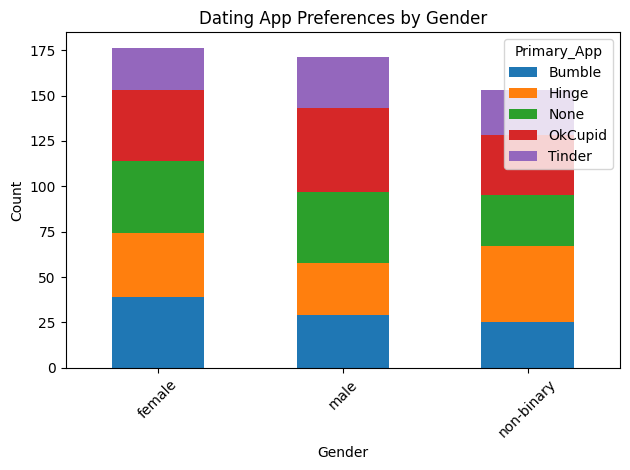

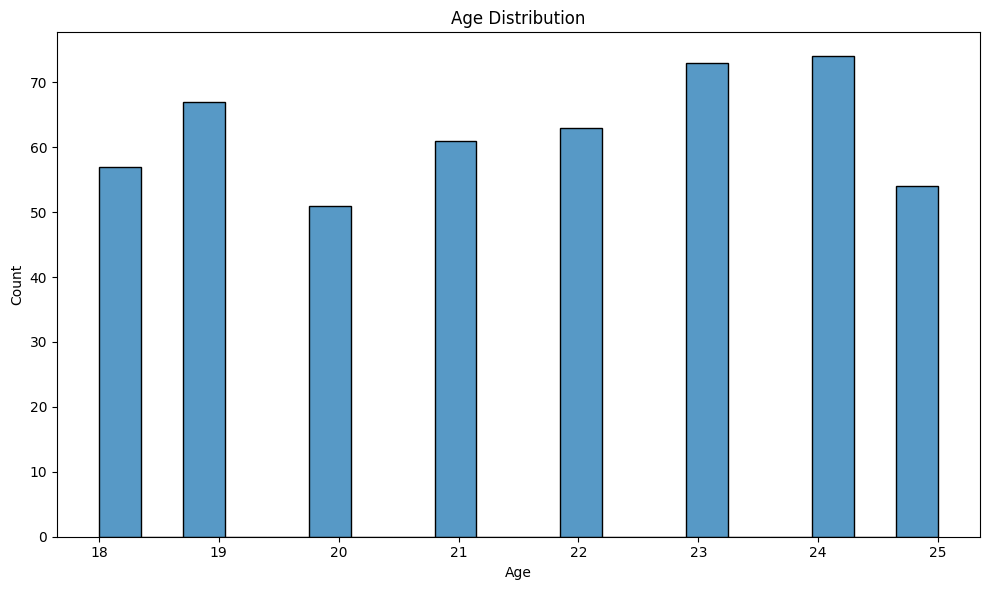

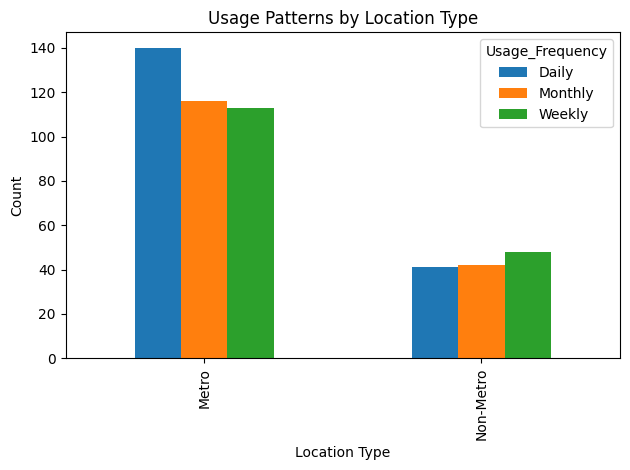

Gender Distribution (%):
Gender
female        35.2
male          34.2
non-binary    30.6
Name: proportion, dtype: float64

Age Group Distribution (%):
Age_Group
21-23    39.4
18-20    35.0
24-26    25.6
Name: proportion, dtype: float64

Location Type Distribution (%):
Location_Type
Metro        73.8
Non-Metro    26.2
Name: proportion, dtype: float64


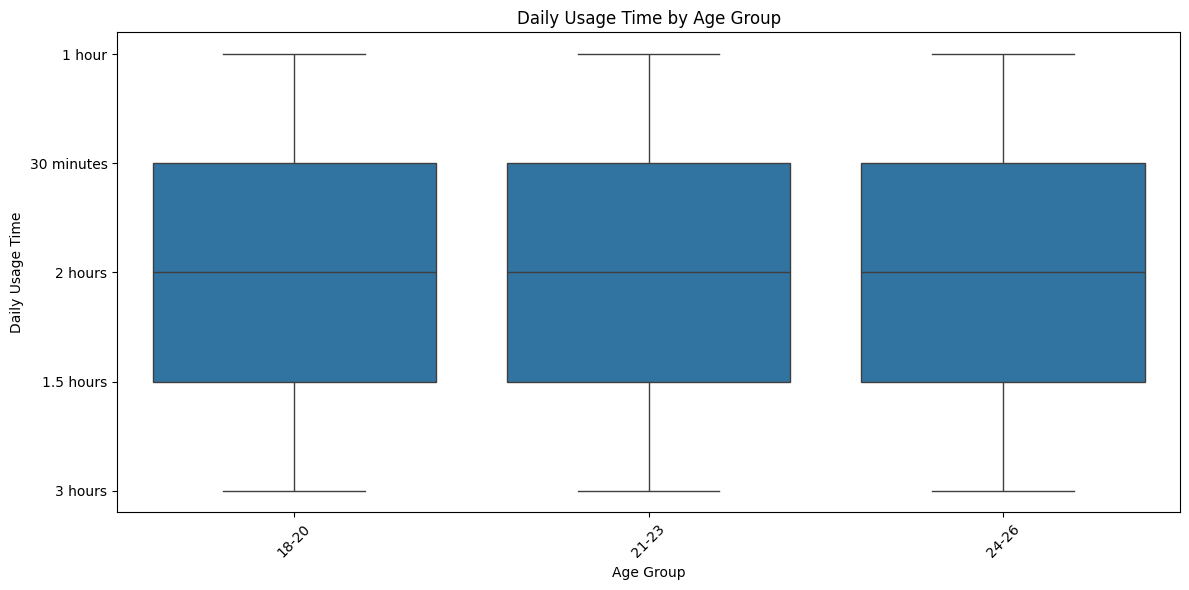

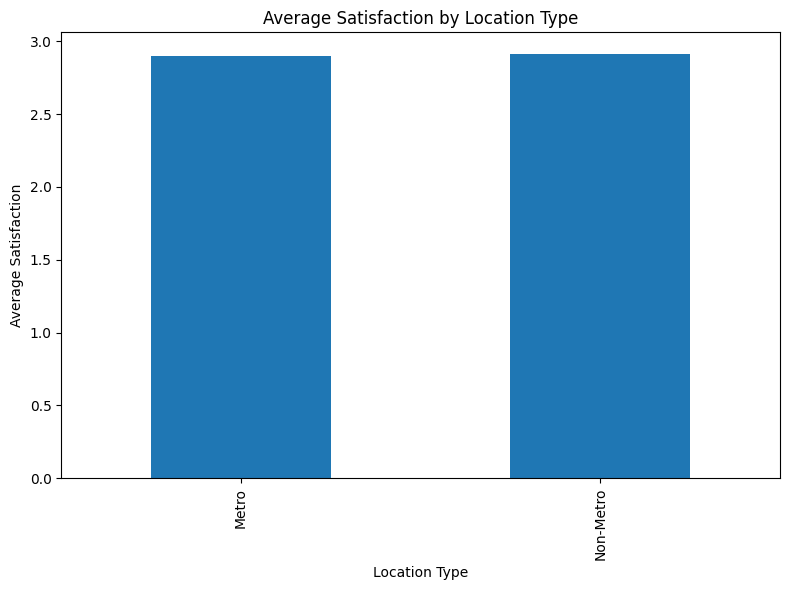

In [3]:
# (EDA) Exploratory Data Analysis

def perform_eda(df):

    plt.figure(figsize=(12, 8))
    
    # Dating app preferences by gender
    app_by_gender = pd.crosstab(df['Gender'], df['Primary_App'])
    ax = app_by_gender.plot(kind='bar', stacked=True)
    plt.title('Dating App Preferences by Gender')
    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Age distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='Age', bins=20)
    plt.title('Age Distribution')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    
    # Usage patterns by location type
    df['Location_Type'] = df['Location'].apply(
        lambda x: 'Metro' if x in ['Mumbai', 'Delhi', 'Bangalore', 'Chennai', 'Kolkata'] else 'Non-Metro'
    )
    location_usage = pd.crosstab(df['Location_Type'], df['Usage_Frequency'])
    location_usage.plot(kind='bar')
    plt.title('Usage Patterns by Location Type')
    plt.xlabel('Location Type')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

perform_eda(cleaned_df)


def analyze_bias(df):

    # Gender distribution
    gender_dist = df['Gender'].value_counts(normalize=True) * 100
    print("Gender Distribution (%):")
    print(gender_dist)
    
    # Age group distribution
    df['Age_Group'] = pd.cut(df['Age'], bins=[17, 20, 23, 26], labels=['18-20', '21-23', '24-26'])
    age_dist = df['Age_Group'].value_counts(normalize=True) * 100
    print("\nAge Group Distribution (%):")
    print(age_dist)
    
    # Location distribution
    location_dist = df['Location_Type'].value_counts(normalize=True) * 100
    print("\nLocation Type Distribution (%):")
    print(location_dist)

analyze_bias(cleaned_df)



def analyze_trends(df):
    # Age group preferences
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Age_Group', y='Daily_Usage_Time', data=df)
    plt.title('Daily Usage Time by Age Group')
    plt.xlabel('Age Group')
    plt.ylabel('Daily Usage Time')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Regional differences
    regional_satisfaction = df.groupby('Location_Type')['Satisfaction'].mean()
    plt.figure(figsize=(8, 6))
    regional_satisfaction.plot(kind='bar')
    plt.title('Average Satisfaction by Location Type')
    plt.xlabel('Location Type')
    plt.ylabel('Average Satisfaction')
    plt.tight_layout()
    plt.show()

analyze_trends(cleaned_df)

In [4]:
# Feature Engineering

def engineer_features(df):

    # Create a copy for feature engineering
    featured_df = df.copy()
    
    # Create active app count
    featured_df['Active_App_Count'] = featured_df.apply(
        lambda x: (1 if x['Primary_App'] != 'None' else 0) + 
                 (len(str(x['Secondary_Apps']).split(',')) if x['Secondary_Apps'] != 'None' else 0),
        axis=1
    )
    
    # Encode categorical variables
    le = LabelEncoder()
    categorical_cols = ['Gender', 'Location_Type', 'Education', 'Occupation']
    
    for col in categorical_cols:
        featured_df[f'{col}_Encoded'] = le.fit_transform(featured_df[col])
    
    # Normalize numerical variables
    scaler = StandardScaler()
    numerical_cols = ['Age', 'Satisfaction', 'Active_App_Count']
    featured_df[['Scaled_' + col for col in numerical_cols]] = scaler.fit_transform(featured_df[numerical_cols])
    
    return featured_df

# Engineer features
featured_df = engineer_features(cleaned_df)

# Display sample of engineered features
print("\nSample of engineered features:")
print(featured_df[['Active_App_Count', 'Gender_Encoded', 'Location_Type_Encoded', 
                  'Scaled_Age', 'Scaled_Satisfaction']].head())


Sample of engineered features:
   Active_App_Count  Gender_Encoded  Location_Type_Encoded  Scaled_Age  \
0                 2               2                      0   -0.700846   
1                 2               0                      0    1.071205   
2                 0               2                      0    1.071205   
3                 1               2                      0    0.185179   
4                 2               1                      0   -1.586871   

   Scaled_Satisfaction  
0             0.759802  
1             1.454320  
2             0.759802  
3             0.065285  
4             0.759802  
